In [1]:
# write your code here
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
☆*°☆*°(∩^o^)~━━  2017/12/1 23:55        
      (ˉ▽￣～) ~~ 一捆好葱 (软件4班饶浩聪) (*˙︶˙*)☆*°
      Fuction： 机器学习lab2(py2.7代码 不兼容3的地方已注释√ ━━━━━☆*°☆*°
"""
from sklearn.datasets import load_svmlight_file
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random


def get_data():
	data = load_svmlight_file("lab_2_Australian_data")
	return data[0], data[1]



# f为假设函数，即目标函数,用于分类,当 f > 0,y = +1 当 f < 0,y = -1 当 f = 0, 该点在分类超平面上
def f(x, w, b):
	f_result = 0
	x = np.ndarray.tolist(x)
	# print x
	for i in range(len(x[0])):
		f_result += x[0][i] * w[i]
	f_result += b
	return f_result

def cal_accuracy(w, b, X_val, y_val):
	x = np.ndarray.tolist(X_val)
	right_num = 0
	for i in range(len(x[0])):
		result = f(X_val[i, :], w, b)
		# print result
		if result > 0 and y_val[i] == 1 or result < 0 and y_val[i] == -1:
			right_num += 1
	return float(right_num) / float(len(x[0]))

def SVM(options):
	X, y = get_data()
	# 将原训练集再切分为2:1的更小训练集和验证集
	X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)
	# 初始化参数的三种方式，共有13个属性，即13个系数
	# b = 0
	b = random.random()
	if options == 1:
		w = [0] * 14
	elif options == 2:
		w = np.random.rand(14)
	else:
		w = np.random.randn(14)
	# w_sum = sum(w)
	# w = [w[i]/w_sum for i in range(14)]
	# print w
	# loss函数为 1/(2*n) * sum([(h(X[i])-y[i])**2 for i in range(n)]) n为向量维度
	# w[i] = w[i] - a * 1/n * sum([(h(X[i])-y[i]) for i in range(n)]) a为学习系数 0.0001 0.0016 0.03
	# a = 0.16
	# 学习步长为aa
	aa = 0.0096
	n = 14
	X_train = X_train.todense()
	X_val = X_val.todense()
	X_size = len(X_train)
	X_val_size = len(X_val)
	loss = sum([w[i] ** 2 for i in range(n)]) + 1.0 / X_size * sum([max(0, 1 - y_train[i] * f(X_train[i, :], w, b)) for i in range(X_size)])
	# print loss

	cnt = 0
	train_loss = []
	val_loss = []
	while True:
		# 对w各分量wi进行下降
		for i in range(n):
			gradient_aver = w[i] + sum([((y_train[k] < 1) * (-y_train[k]) * X_train[k, i]) for k in range(X_size)]) / X_size
			# print gradient_aver
			w[i] -= gradient_aver * aa
		# print cal_accuracy(w, b, X_train, y_train)
		new_loss = sum([w[i] ** 2 for i in range(n)]) + 1.0 / X_size * sum([max(0, 1 - y_train[i] * f(X_train[i, :], w, b)) for i in range(X_size)])
		v_loss = sum([w[i] ** 2 for i in range(n)]) + 1.0 / X_val_size * sum([max(0, 1 - y_val[i] * f(X_val[i, :], w, b)) for i in range(X_val_size)])
		if abs(loss - new_loss) > 0.00001:
			loss = new_loss
		else:
			break
		train_loss.append(loss)
		val_loss.append(v_loss)
		cnt += 1
		if options == 1 and cnt > 50:
			break
		elif options == 2 and cnt > 200:
			break
		elif cnt > 280:
			break
	plt.figure(figsize=(8,6))
	plt.xlabel('Gradient descent - Iteration times')
	plt.ylabel('Loss')
	plt.plot(range(cnt), train_loss, 'o-', label=u"Training Set")
	plt.plot(range(cnt), val_loss, 'r-', label=u"Validation set")
	plt.legend()
	plt.grid()
	plt.show()

F:\Anaconda3\An3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


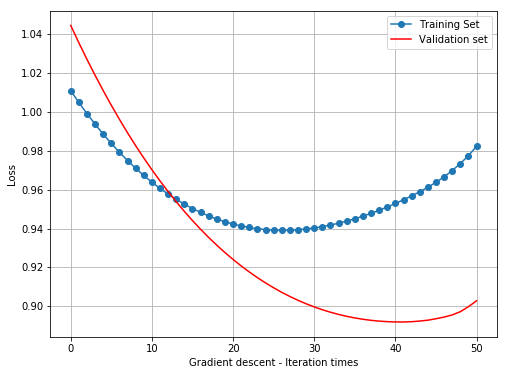

In [2]:
SVM(1) # 模型参数 - > 各分量权重初始化为 0

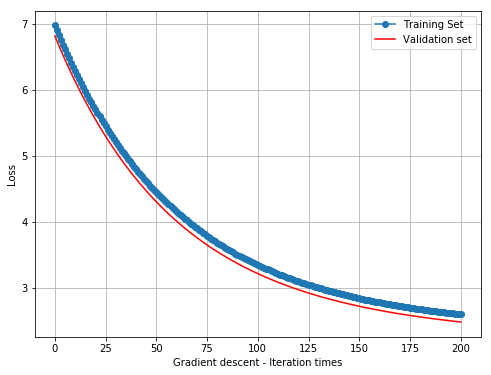

In [3]:
SVM(2) # 模型参数 - > 各分量权重随机初始化

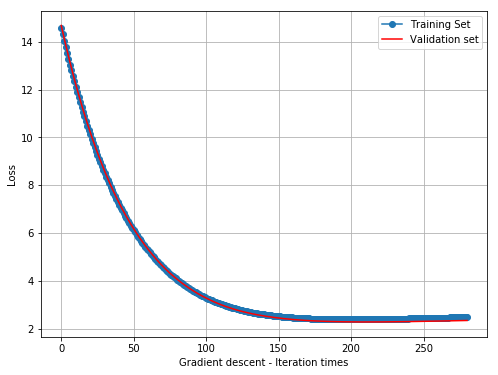

In [4]:
SVM(3) # 模型参数 - > 各分量权重高斯分布初始化